In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)


In [ ]:

data = load_breast_cancer()
print("Dataset description:")
print(data.DESCR[:500] + "...")

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print(f"\nDataset shape: {df.shape}")
print(f"\nFeature names: {list(data.feature_names)[:10]}...")
print(f"\nTarget classes: {data.target_names}")


Dataset description:
.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (...

Dataset shape: (569, 31)

Feature names: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]...

Target classes: ['malignant' 'benign']


In [ ]:

print("Dataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness e

In [ ]:

print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")


print("\nTarget distribution:")
print(df['target'].value_counts())
print(f"\nTarget distribution (%):\n{df['target'].value_counts(normalize=True) * 100}")


Missing values per column:
Series([], dtype: int64)
No missing values found!

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Target distribution (%):
target
1    62.741652
0    37.258348
Name: proportion, dtype: float64


In [ ]:

mean_radius = df['mean radius']
worst_radius = df['worst radius']
mean_texture = df['mean texture']
target = df['target']


def assign_priority(row):
    """
    Assign priority based on tumor characteristics:
    - High priority: Malignant (0) with large size or high texture
    - Medium priority: Malignant with moderate characteristics or large benign
    - Low priority: Small benign tumors
    """
    is_malignant = row['target'] == 0  
    radius = row['mean radius']
    texture = row['mean texture']
    

    radius_high = df['mean radius'].quantile(0.75)
    radius_medium = df['mean radius'].quantile(0.5)
    texture_high = df['mean texture'].quantile(0.75)
    
    if is_malignant:
        if radius > radius_high or texture > texture_high:
            return 'high'  
        else:
            return 'medium'  
    else:  
        if radius > radius_high:
            return 'medium'  
        else:
            return 'low'  
df['priority'] = df.apply(assign_priority, axis=1)

print("Priority distribution:")
print(df['priority'].value_counts())
print(f"\nPriority distribution (%):\n{df['priority'].value_counts(normalize=True) * 100}")


Priority distribution:
priority
low       351
high      170
medium     48
Name: count, dtype: int64

Priority distribution (%):
priority
low       61.687170
high      29.876977
medium     8.435852
Name: proportion, dtype: float64


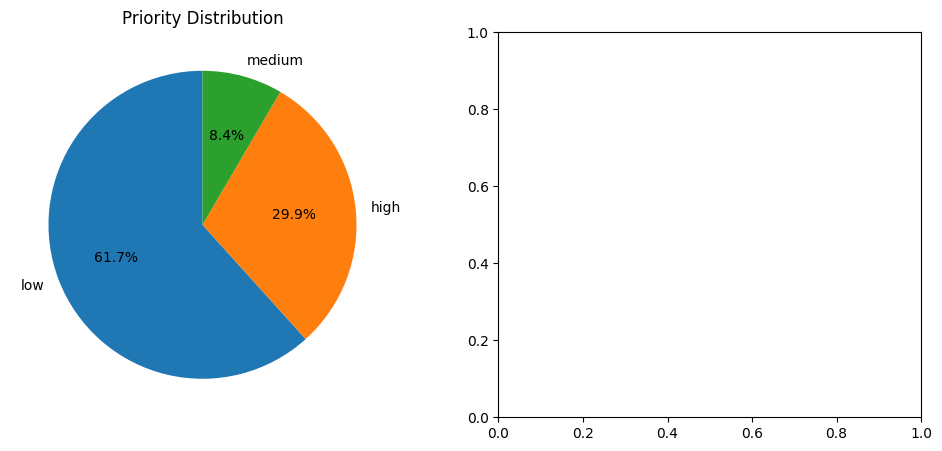

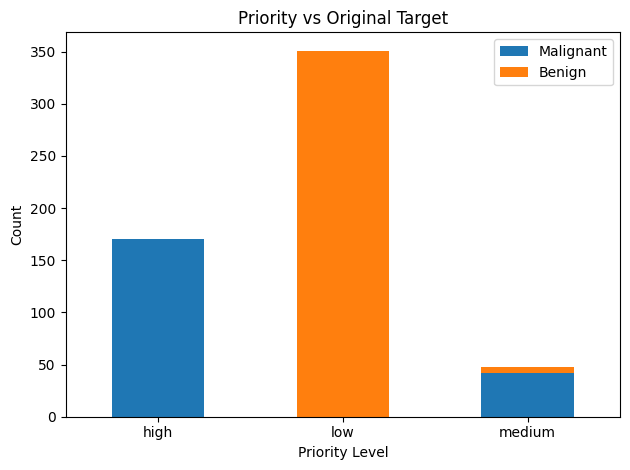

In [ ]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
priority_counts = df['priority'].value_counts()
plt.pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Priority Distribution')


plt.subplot(1, 2, 2)
priority_target = pd.crosstab(df['priority'], df['target'])
priority_target.plot(kind='bar', stacked=True)
plt.title('Priority vs Original Target')
plt.xlabel('Priority Level')
plt.ylabel('Count')
plt.legend(['Malignant', 'Benign'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [ ]:

X = df.drop(['target', 'priority'], axis=1)
y = df['priority']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {list(X.columns)}")


Feature matrix shape: (569, 30)
Target vector shape: (569,)
Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [ ]:

if X.isnull().sum().sum() > 0:
    print("Handling missing values...")
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print("Missing values imputed with median.")
else:
    print("No missing values to handle.")

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("\nFeatures have been standardized.")
print(f"Mean after scaling: {X_scaled.mean().mean():.6f}")
print(f"Std after scaling: {X_scaled.std().mean():.6f}")


No missing values to handle.

Features have been standardized.
Mean after scaling: -0.000000
Std after scaling: 1.000880


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")


print("\nTraining set priority distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set priority distribution:")
print(y_test.value_counts(normalize=True))


Training set size: 455 samples
Testing set size: 114 samples
Feature dimensions: 30

Training set priority distribution:
priority
low       0.617582
high      0.298901
medium    0.083516
Name: proportion, dtype: float64

Testing set priority distribution:
priority
low       0.614035
high      0.298246
medium    0.087719
Name: proportion, dtype: float64


In [ ]:

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training completed!")


y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print(f"\nPredictions shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")


Training Random Forest model...
Model training completed!

Predictions shape: (114,)
Prediction probabilities shape: (114, 3)


In [ ]:

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")


print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


=== MODEL PERFORMANCE METRICS ===
Accuracy: 0.9298
F1-Score (macro): 0.8480
F1-Score (weighted): 0.9233

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        high       0.91      0.91      0.91        34
         low       0.93      1.00      0.97        70
      medium       1.00      0.50      0.67        10

    accuracy                           0.93       114
   macro avg       0.95      0.80      0.85       114
weighted avg       0.93      0.93      0.92       114



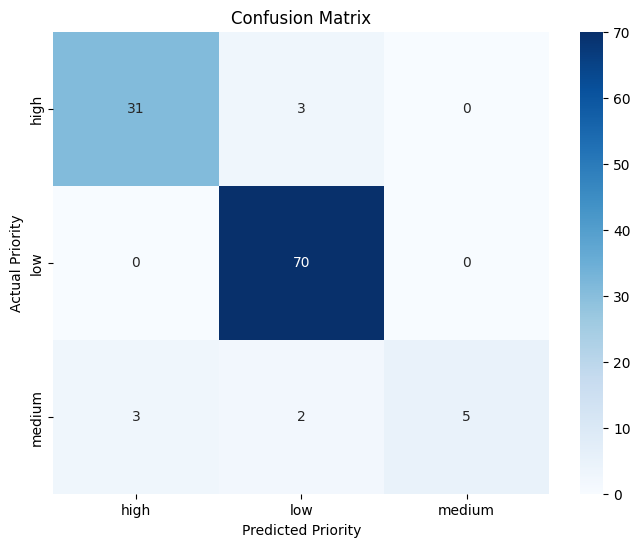


Per-class Performance:
high: Precision=0.912, Recall=0.912
low: Precision=0.933, Recall=1.000
medium: Precision=1.000, Recall=0.500


In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['high', 'low', 'medium'], 
            yticklabels=['high', 'low', 'medium'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Priority')
plt.ylabel('Actual Priority')
plt.show()


print("\nPer-class Performance:")
for i, priority in enumerate(['high', 'low', 'medium']):
    true_positives = cm[i, i]
    precision = true_positives / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = true_positives / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    print(f"{priority}: Precision={precision:.3f}, Recall={recall:.3f}")


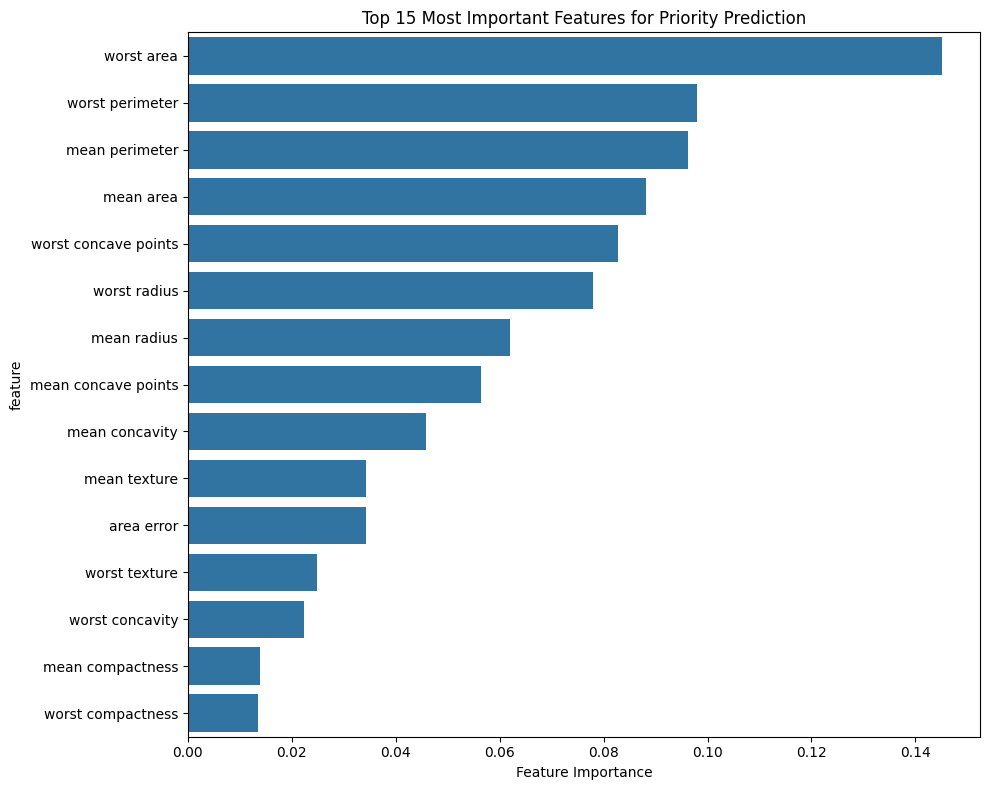

Top 10 Most Important Features:
                 feature  importance
23            worst area    0.145177
22       worst perimeter    0.098056
2         mean perimeter    0.096239
3              mean area    0.088172
27  worst concave points    0.082838
20          worst radius    0.077939
0            mean radius    0.061974
7    mean concave points    0.056399
6         mean concavity    0.045897
1           mean texture    0.034184


In [ ]:

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance')
plt.title('Top 15 Most Important Features for Priority Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))


In [ ]:

from sklearn.model_selection import StratifiedKFold


cv_scores = cross_val_score(rf_model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
cv_f1_scores = cross_val_score(rf_model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro')

print("=== CROSS-VALIDATION RESULTS ===")
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"CV F1-Score (macro): {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")
print(f"Individual CV Accuracy Scores: {cv_scores}")
print(f"Individual CV F1 Scores: {cv_f1_scores}")


=== CROSS-VALIDATION RESULTS ===
CV Accuracy: 0.9314 (+/- 0.0208)
CV F1-Score (macro): 0.8386 (+/- 0.0856)
Individual CV Accuracy Scores: [0.93859649 0.92982456 0.92105263 0.94736842 0.92035398]
Individual CV F1 Scores: [0.92152778 0.82920084 0.82930121 0.81018519 0.80264716]


In [ ]:

print("=== FINAL MODEL PERFORMANCE SUMMARY ===")
print(f"Dataset: Breast Cancer Wisconsin (569 samples, 30 features)")
print(f"Task: Multi-class priority prediction (high/medium/low)")
print(f"Model: Random Forest Classifier")
print(f"")
print(f"PERFORMANCE METRICS:")
print(f"- Test Accuracy: {accuracy:.4f}")
print(f"- Test F1-Score (macro): {f1_macro:.4f}")
print(f"- Test F1-Score (weighted): {f1_weighted:.4f}")
print(f"- Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"- Cross-validation F1-Score: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")


print(f"\n=== RESOURCE ALLOCATION INSIGHTS ===")
priority_dist = y_test.value_counts(normalize=True)
print(f"Expected case distribution:")
for priority, percentage in priority_dist.items():
    print(f"- {priority.capitalize()} priority: {percentage:.1%}")

print(f"\nMost important features for triage:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values):
    print(f"{i+1}. {feature}: {importance:.3f}")

print(f"\nRecommendations:")
print(f"- Focus resources on {priority_dist.index[0]} priority cases ({priority_dist.iloc[0]:.1%} of cases)")
print(f"- Use {feature_importance.iloc[0]['feature']} as primary screening criterion")
print(f"- Model achieves {accuracy:.1%} accuracy in priority assignment")


=== FINAL MODEL PERFORMANCE SUMMARY ===
Dataset: Breast Cancer Wisconsin (569 samples, 30 features)
Task: Multi-class priority prediction (high/medium/low)
Model: Random Forest Classifier

PERFORMANCE METRICS:
- Test Accuracy: 0.9298
- Test F1-Score (macro): 0.8480
- Test F1-Score (weighted): 0.9233
- Cross-validation Accuracy: 0.9314 (+/- 0.0208)
- Cross-validation F1-Score: 0.8386 (+/- 0.0856)

=== RESOURCE ALLOCATION INSIGHTS ===
Expected case distribution:
- Low priority: 61.4%
- High priority: 29.8%
- Medium priority: 8.8%

Most important features for triage:
1. worst area: 0.145
2. worst perimeter: 0.098
3. mean perimeter: 0.096
4. mean area: 0.088
5. worst concave points: 0.083

Recommendations:
- Focus resources on low priority cases (61.4% of cases)
- Use worst area as primary screening criterion
- Model achieves 93.0% accuracy in priority assignment


In [ ]:

import joblib


joblib.dump(rf_model, 'breast_cancer_priority_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("Model and preprocessor saved successfully!")
print("Files created:")
print("- breast_cancer_priority_model.pkl")
print("- feature_scaler.pkl")


print("\nExample usage:")
print("# Load model")
print("model = joblib.load('breast_cancer_priority_model.pkl')")
print("scaler = joblib.load('feature_scaler.pkl')")
print("# Make prediction")
print("new_data_scaled = scaler.transform(new_data)")
print("priority = model.predict(new_data_scaled)")


def predict_priority(features, model=rf_model, scaler=scaler):
    """
    Predict priority for new breast cancer cases
    
    Args:
        features: numpy array or list of 30 feature values
        model: trained Random Forest model
        scaler: fitted StandardScaler
    
    Returns:
        priority: predicted priority level (high/medium/low)
        probability: prediction probabilities for each class
    """

    if len(features) == 30:
        features = np.array(features).reshape(1, -1)
    
    
    features_scaled = scaler.transform(features)
    
    
    priority = model.predict(features_scaled)
    probability = model.predict_proba(features_scaled)
    
    return priority[0], probability[0]

print("\n\nSample prediction function created: predict_priority()")
print("Use this function to make predictions on new data.")


Model and preprocessor saved successfully!
Files created:
- breast_cancer_priority_model.pkl
- feature_scaler.pkl

Example usage:
# Load model
model = joblib.load('breast_cancer_priority_model.pkl')
scaler = joblib.load('feature_scaler.pkl')
# Make prediction
new_data_scaled = scaler.transform(new_data)
priority = model.predict(new_data_scaled)


Sample prediction function created: predict_priority()
Use this function to make predictions on new data.
